Task 1
If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:

1. Which performance metrics would you use to evaluate your model’s predictions?

To evaluate our model’s performance, we would use the following metrics. Mean Squared Error and Root Mean Squared Error as they're fairly common metric for measuring the differences between the predicted and the actual values, the root of MSE expresses this error in the same units as the target variable, allowing for more intuitive interpretation. We would also make use of Median Absolute Error, which is similar to MSEand focuses on the median of the absolute errors, we included it as it aligns well with our goal of predicting the medians. Lastly we chose the R² score, as it tells us the proportion of variance in the predicted values explained by the model, indicating how well the model captures underlying patterns in the data.

2. Does the selection of the performance metric depend on the type of the response
variables? Explain your reasoning.

Yes, naturally different performance metrics are more accustomed to different responses, given if our response varaible is regressive or catergorical would result in different performance metrics being used. For example we particularly chose Median Absolute Error when considering the response variable as it conceptually aligns with our predicted target.

3. Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you
use given that the objective is to build a predictive model able to generalise across
participants (i.e., make accurate predictions for unseen participants)? Justify your
choice.

We would make use of Leave-One-Group-Out a cross-validation technique that aligns with our dataset. In LOGO we keep the data of the participants data used for training and testing seperate, this ensures that during the test set it mirrors a real-world scenario where the model where we would be expected to predict arousal and valence levels for entirely new unseen participant. This approach would give us a strict separation between training and testing data at the participant level, preventing data leakage and overfitting that could occur if information from the same individual appeared in both sets.

Task 2 Using the provided audio features, build predictive models for arousal and valence:

1. Develop a predictive model for each response variable (arousal and valence) using
some or all of the provided audio features as explanatory variables

First we preprocessed the dataset using feature selection; separating the target variables, median_arousal and median_valence, from the feature set. These will serve as the outputs our models aim to predict and therefore they should not be included in the training dataset. We also excluded the Participant ID as this is a categorical identifier unique to each individual, including this as a feature would make sense for a regreseeive model.

However, the Participant ID played a crucial role for implementing LOGO as discussed previously. Like this we can be sure that no data leakage could occur during training, if we simply split a participants recordings into a training and test sets the model may easily perform unrealisitically well (given it already has training knowledge regarding them), rather than a real life scenario where an unseen participant would need to be identified.

We then used the standard scaler to scale the data, naturally we didnt need to use Label Encoding or One-Hot Encoding as there are no catergorical values in the resulting dataset.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

df = pd.read_csv("project_data.csv")
scaler = StandardScaler()

y_arousal = pd.concat([df['Participant'], df['median_arousal']], axis=1)
y_valence = pd.concat([df['Participant'], df['median_valence']], axis=1)
df = df.drop(columns=['median_arousal', 'median_valence'])

# Get participant list
last_participant = df.iloc[[-1]]
participant_list = list(range(1, int(last_participant['Participant']) + 1))

# 80/20 test-train split
test_participants_index = random.sample(participant_list, 2)
train_participants_index = [item for item in participant_list if item not in test_participants_index]

x_test = pd.concat([df[df['Participant'] == index] for index in test_participants_index])
x_train = pd.concat([df[df['Participant'] == index] for index in train_participants_index])
y_test_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in test_participants_index])
y_test_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in test_participants_index])
y_train_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in train_participants_index])
y_trian_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in train_participants_index]) 

x_test = x_test.drop(columns=['Participant'])
x_train = x_train.drop(columns=['Participant'])
y_test_arousal = y_test_arousal.drop(columns=['Participant'])
y_test_valence = y_test_valence.drop(columns=['Participant'])
y_train_arousal = y_train_arousal.drop(columns=['Participant'])
y_trian_valence = y_trian_valence.drop(columns=['Participant'])

x_test_scaled = scaler.fit_transform(x_test)
x_train_scaled = scaler.fit_transform(x_train)

C:\Users\gianm\AppData\Local\Temp\ipykernel_102276\3097591752.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  participant_list = list(range(1, int(last_participant['Participant']) + 1))


The first task when selecticg a model is to identify if the problem is a regression or classification problem, given that we have to predict  the scaler values of median valence and arousal this is clearly a regression problem. Given this dataset presents a high-dimensionality problem, which traditional machine learning methods often struggle to handle, we made use of a regularization method Least Absolute Shrinkage and Selection Operator. Lasso regularization penalizes features to effectively exclude temselves by reducing them to zero, making it an ideal fit for this dataset.

In [ ]:
from sklearn.linear_model import LassoCV

lasso_cv_arousal = LassoCV(cv=10, random_state=0)
lasso_cv_arousal.fit(x_train_scaled, y_train_arousal.values.ravel())
selected_features_mask_arousal = lasso_cv_arousal.coef_ != 0
x_train_selected_arousal = x_train_scaled[:, selected_features_mask_arousal]
x_test_selected_arousal = x_test_scaled[:, selected_features_mask_arousal]

lasso_cv_valence = LassoCV(cv=10, random_state=0)
lasso_cv_valence.fit(x_train_scaled, y_trian_valence.values.ravel())
selected_features_mask_valence = lasso_cv_valence.coef_ != 0
x_train_selected_valence = x_train_scaled[:, selected_features_mask_valence]
x_test_selected_valence = x_test_scaled[:, selected_features_mask_valence]

c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03663492602390761, tolerance: 0.01781022162389442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0454929339561545, tolerance: 0.01781022162389442
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04093762360793107, tolerance: 0.01781022162

Iterative Generalized Linear Models (GLMs), offer a compelling balance between interpretability and efficiency, making them especially valuable in scenarios where understanding feature effects is as important as predictive accuracy. Unlike Random Forests and Support Vector Machine,  which often function as black-box models with limited transparency, Iterative GLMs provide explicit model coefficients that quantify the relationship between each input feature and the target variable. Compared to standard Logistic or Linear Regression, Iterative GLMs are more flexible and stable in handling non-Gaussian distributions and can provide more reliable estimates through their iterative fitting process. 

In [4]:
import statsmodels.api as sm

x_train_glm_valence = sm.add_constant(x_train_selected_valence)
x_test_glm_valence = sm.add_constant(x_test_selected_valence)
x_train_glm_arousal = sm.add_constant(x_train_selected_arousal)
x_test_glm_arousal = sm.add_constant(x_test_selected_arousal)

glm_model_arousal = sm.GLM(y_train_arousal.values.ravel(), x_train_glm_arousal, family=sm.families.Gaussian())
glm_results_arousal = glm_model_arousal.fit()
glm_model_valence = sm.GLM(y_trian_valence.values.ravel(), x_train_glm_valence, family=sm.families.Gaussian())
glm_results_valence = glm_model_valence.fit()


glm_predictions_valence = glm_results_valence.predict(x_test_glm_valence)
glm_predictions_arousal = glm_results_arousal.predict(x_test_glm_arousal)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

glm_mse_valence = mean_squared_error(y_test_valence, glm_predictions_valence)
glm_mse_arousal = mean_squared_error(y_test_arousal, glm_predictions_arousal)
glm_rmse_valence =  np.sqrt(glm_mse_valence)
glm_rmse_arousal =  np.sqrt(glm_mse_arousal)
r2_valence = r2_score(y_test_valence, glm_predictions_valence)
r2_arousal = r2_score(y_test_arousal, glm_predictions_arousal)

print(glm_results_arousal.summary())
print(f"\nGLM MSE (arousal): {glm_mse_arousal:.4f}")
print(f"\nGLM RMSE (arousal): {glm_rmse_arousal:.4f}")
print(f"\nGLM R^2 (arousal): {r2_arousal:.4f}")
print(glm_results_valence.summary())
print(f"\nGLM MSE (valence): {glm_mse_valence:.4f}")
print(f"\nGLM RMSE (valence): {glm_rmse_valence:.4f}")
print(f"\nGLM R^2 (valence): {r2_valence:.4f}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5792
Model:                            GLM   Df Residuals:                     5768
Model Family:                Gaussian   Df Model:                           23
Link Function:               Identity   Scale:                        0.025981
Method:                          IRLS   Log-Likelihood:                 2365.1
Date:                Mon, 19 May 2025   Deviance:                       149.86
Time:                        18:58:27   Pearson chi2:                     150.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2466
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      1.713      0.0

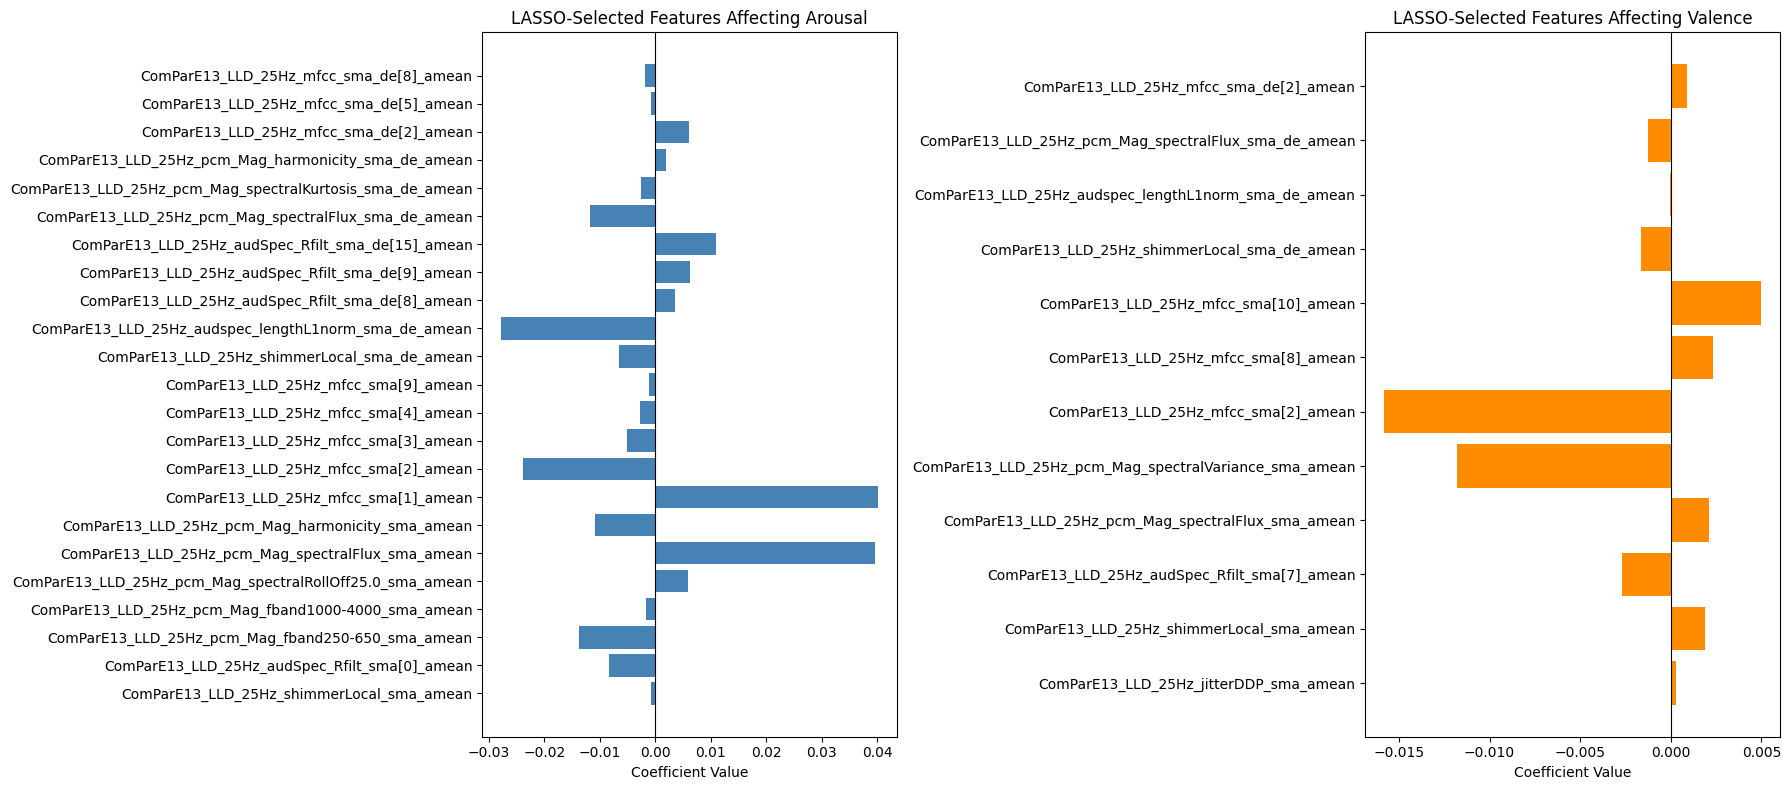

Number of Features used for Arousal: 23
Number of Features used for Valence: 12


In [6]:
import matplotlib.pyplot as plt
lasso_coef_arousal = lasso_cv_arousal.coef_
lasso_coef_valence = lasso_cv_valence.coef_
feature_names = x_train.columns
selected_features_arousal = np.array(feature_names)[lasso_coef_arousal != 0]
selected_coefs_arousal = lasso_coef_arousal[lasso_coef_arousal != 0]
selected_features_valence = np.array(feature_names)[lasso_coef_valence != 0]
selected_coefs_valence = lasso_coef_valence[lasso_coef_valence != 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
axes[0].barh(selected_features_arousal, selected_coefs_arousal, color='steelblue')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title("LASSO-Selected Features Affecting Arousal")
axes[0].set_xlabel("Coefficient Value")
axes[1].barh(selected_features_valence, selected_coefs_valence, color='darkorange')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title("LASSO-Selected Features Affecting Valence")
axes[1].set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

print(f"Number of Features used for Arousal: {len(x_train_selected_arousal[0])}")
print(f"Number of Features used for Valence: {len(x_train_selected_valence[0])}")

 Task 3 
 In  this  task,  you  will  identify  similar  observations  captured  from  the  first  participant 
(participant ID = 1). Complete the following steps: 

1. Create  groups  of  similar  observations  from  the  first  participant  by  proposing  and 
implementing two suitable algorithms. 

We created a subset of the dataset by selecting only participant 1's data, we subsequently dropped the partipants column as this data is uneccassary. We also removed the median_arousal and median_variance as this section is based on creating groups of similar observations (features) and these last two columns are annotations/scores.

In [ ]:
df = pd.read_csv("project_data.csv")

participant_df = df[df["Participant"] == 1]
participant_df = participant_df.drop(columns=["Participant",'median_arousal', 'median_valence'])

df.to_csv('out.csv',index=False)


     ComParE13_LLD_25Hz_F0final_sma_amean  \
0                               -1.665550   
1                               -1.547531   
2                               -0.977216   
3                               -0.218558   
4                                0.075725   
..                                    ...   
720                              0.834987   
721                              0.995974   
722                              1.229950   
723                              1.597127   
724                              2.174707   

     ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean  \
0                                            -1.018178    
1                                            -0.988172    
2                                            -0.724075    
3                                             0.150993    
4                                             0.221303    
..                                                 ...    
720                                           

For this question I would like to perform Hierarchical clustering using complete linkage and K-mediods with random initialization to further minimize the optimization criterion along with forward step wise assignment.

     ComParE13_LLD_25Hz_F0final_sma_amean  \
0                               -1.665550   
1                               -1.547531   
2                               -0.977216   
3                               -0.218558   
4                                0.075725   
..                                    ...   
720                              0.834987   
721                              0.995974   
722                              1.229950   
723                              1.597127   
724                              2.174707   

     ComParE13_LLD_25Hz_voicingFinalUnclipped_sma_amean  \
0                                            -1.018178    
1                                            -0.988172    
2                                            -0.724075    
3                                             0.150993    
4                                             0.221303    
..                                                 ...    
720                                           

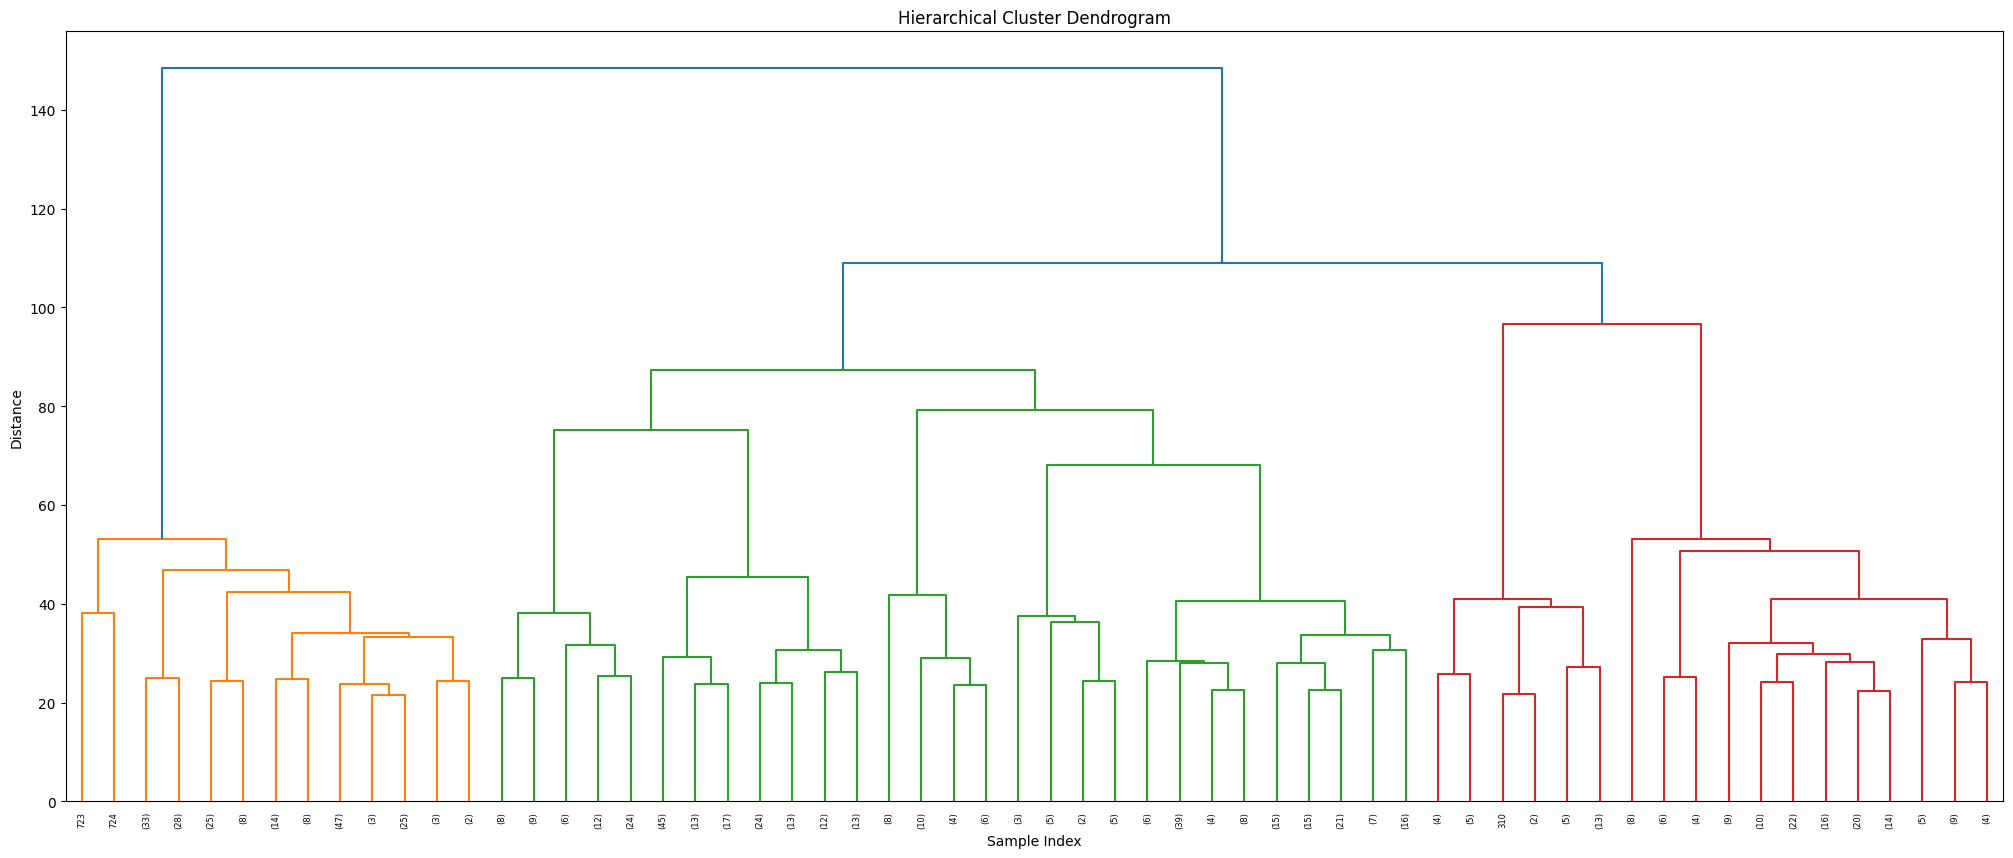

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

print(participant_df)
plt.figure(figsize=(25,10))
dn = dendrogram(linkage(participant_df,'ward'),truncate_mode='lastp',p=60)
plt.title('Hierarchical Cluster Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

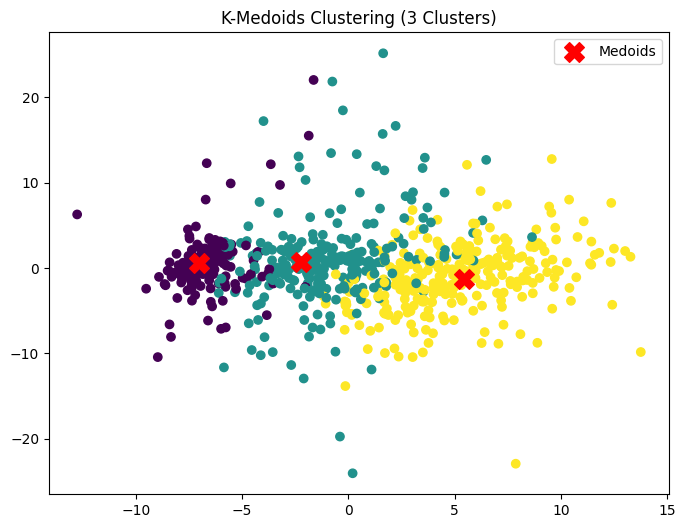

In [ ]:

from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

#kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)
kmedoids = KMedoids(n_clusters=3, random_state=42)
labels = kmedoids.fit_predict(participant_df)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(participant_df)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(X_pca[kmedoids.medoid_indices_, 0], X_pca[kmedoids.medoid_indices_, 1], c='red', marker='X', s=200, label='Medoids')
plt.title('K-Medoids Clustering (3 Clusters)')
plt.legend()
plt.show()